tgb - 3/4/2020 - Preparing figures for our March 2020 PRL submission. Draws heavily from notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/022_Figure_Conserving_NN.ipynb]

# Initialization

## Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import pickle

# Otherwise tensorflow will use ALL your GPU RAM for no reason
#limit_mem()

/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Plot properties

In [2]:
#TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
#config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
config_fn = '/export/home/tbeucler/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
#data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
data_fn = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=fz)
# mpl.rcParams['lines.linewidth'] = lw
# plt.close('all')

In [4]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Figure 3

Old version at [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/022_Figure_Conserving_NN.ipynb]

## Load data to plot Figure 3a

In [5]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
NNarray = ['MLRL0','JNNL','JNNL0.01','JNNC']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
DATASET = ['train','valid','test']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [6]:
# Save reduced data to make figure
pathHOME = '/export/home/tbeucler/'
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

Cross-platform errors at [https://stackoverflow.com/questions/14959495/pickle-cross-platform-dict-attribute-error]

In [7]:
# Load LCnet diagnostics
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','rb')
S = pickle.load(hf)
hf.close()

In [8]:
# Load comparison between UCnet, linear, etc.
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S2 = pickle.load(hf)
hf.close()

In [9]:
S.keys()

dict_keys(['MSEv', 'MSEt', 'RESt', 'lev'])

In [9]:
MSEplot = {}
PENplot = {}

for j,datas in enumerate(DATASET):
    #print('datas=',datas)
    MSEplot[datas] = {}
    PENplot[datas] = {}
    
    for alpha in alpha_array:
        #print('alpha = ',str(alpha))
        MSEplot[datas][alpha] = np.log10(S['MSEt'][datas][alpha][0])
        PENplot[datas][alpha] = np.log10(S['RESt'][datas][alpha][0])
        
    for NNs in NNarray:
        MSEplot[datas][NNs] = np.log10(S2['MSEt'][datas][NNs][0])
        PENplot[datas][NNs] = np.log10(S2['RESt'][datas][NNs][0])

## Load data to plot Figure 3b

In [10]:
var = 'Enthalpy'
lat_ind = np.arange(0,64)
nt = 100

if var=='Water':
    Bdic = ['TOT','LHF','PREC','WAT']; 
    Rdic = ['TOT','PREC','WAT','CROSS']
elif var=='Enthalpy':
    Bdic = ['TOT','THERMO','RAD','PHAS','SHFLX'];
    Rdic = ['TOT','THERMO','RAD','PHAS','SHFLX','CROSS'];
    
import pickle
M = {}
for i,NNs in enumerate(NNarray):
    print('i=',i,'NNs=',NNs,'           ',end='\r')
    M[NNs] = {}
    for j,datas in enumerate(DATASET):
        #print('j=',j,'datas=',datas,'           ')
        filename = pathPKL+'2020_03_09_018_ENTdiagno'+NNs+datas+str(nt)+'.pkl'
        hf = open(filename,'rb')
        M[NNs][datas] = pickle.load(hf)

In [11]:
cplot = ['k','g','r','b']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNplot = ['JNNL','JNNL0.01','MLRL0','JNNC']
LAB = {}
LAB['THERMO'] = [r'$\mathrm{UCnet}$',r'$\mathrm{LCnet_{0.01}}$',r'$\mathrm{Linear}$',r'$\mathrm{ACnet}$']
LAB['TOT'] = ['','','','']
NNsREF = 'JNNC'
ZORD = [0,1]
LW = [lw/2,lw]
LS = ['--','-']

In [12]:
hf = open(pathPKL+'2020_03_13_coor.pkl','rb')
S = pickle.load(hf)
coor = S['coor']

## Make both figures on same plot

In [13]:
datas = 'test'

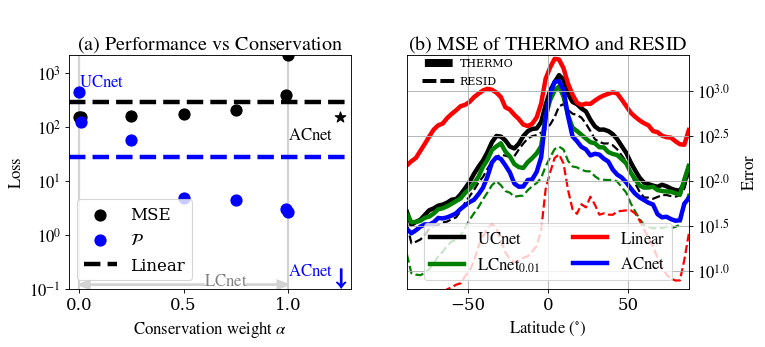

In [14]:
f = plt.figure(num=None, figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
plt.gcf().subplots_adjust(bottom=0.15) # Make room for xlabels

### Subplot 1 ###

ax = f.add_subplot(1,2,1)
MSEs = {}; PENs = {};

plt.axvline(x=0,color='lightgray',linewidth=lw/2,zorder=0)
plt.axvline(x=1,color='lightgray',linewidth=lw/2,zorder=0)

STR = 'MLRL0'
Hlin1 = plt.axhline(y=MSEplot[datas][STR],c='k',linestyle='--',zorder=1)
Hlin2 = plt.axhline(y=PENplot[datas][STR],c='b',linestyle='--',zorder=1)

for alpha in alpha_array:
    STR = alpha
    MSEs[str(alpha)] = plt.scatter(alpha,MSEplot[datas][STR],c='k',s=siz)
    PENs[str(alpha)] = plt.scatter(alpha,PENplot[datas][STR],c='b',s=siz)

STR = 'JNNC'
MSEs['NNA'] = plt.scatter(XNNA,MSEplot[datas][STR],c='k',s=siz,marker='*')
PENs['NNA'] = plt.scatter(XNNA,YMIN+0.2,c='b',s=3*siz,marker="$\downarrow$")
MSEt = plt.text(XNNA-XTEXT,MSEplot[datas][STR]-YTEXT-0.1,s='$\mathrm{ACnet}$',color='k')
PENt = plt.text(XNNA-XTEXT,YMIN+0.1+YTEXT/2,s='$\mathrm{ACnet}$',color='b')
PENu = plt.text(0,2.75,s='$\mathrm{UCnet}$',color='b')
    
plt.xlim((-0.05,1.3))
plt.ylim((YMIN,3.33))

plt.xlabel(r'$\mathrm{Conservation\ weight\ }\alpha$')
plt.ylabel(r'$\mathrm{Loss}$')
plt.title(r'$\mathrm{\left(a\right)\ }\mathrm{Performance\ vs\ Conservation}$')

plt.legend((MSEs['0'],PENs['0'],Hlin1),\
           ('MSE','$\cal{P}$','Linear'),
          loc='lower left')

# Add LCnet legend
plt.arrow(0.6, -0.925, -0.55, 0, color='lightgray', linewidth=lw/2,head_width=0.15,head_length=0.05)
plt.arrow(0.8, -0.925, 0.15, 0, color='lightgray', linewidth=lw/2,head_width=0.15,head_length=0.05)
PENu = plt.text(0.6,-0.925,s='$\mathrm{LCnet}$',color='gray')

plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax.get_yticklabels()]
for ilab,lab in enumerate(labels):
    #print(ilab,lab)
    labels[ilab]='$10^{'+lab+'}$';
ax.set_yticklabels(labels);

### Subplot 2 ###

ax2 = f.add_subplot(1,2,2)
MSEs = {}; PENs = {};

ETHERMOs = {}; ETOTs = {};
for iVAR,var in enumerate(['TOT','THERMO']):
    for imodel,NNs in enumerate(NNplot):
        ETHERMOs[NNs] = plt.plot(coor.lat,\
                                 np.log10(M[NNs][datas]['err'][var][:,:,0].mean(axis=1)),\
                                 color=cplot[imodel],label=LAB[var][imodel],\
                                 zorder=ZORD[iVAR],lw=LW[iVAR],linestyle=LS[iVAR])

plt.text(-80,3,s='-',color='k',size=siz)
plt.text(-80,2.95,s='--',color='k',size=siz/2)
plt.text(-55,3.275,s='THERMO',color='k',fontsize=2*fz/3)
plt.text(-55,3.075,s='RESID',color='k',fontsize=2*fz/3)
        
plt.grid()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.xlim((np.min(coor.lat),np.max(coor.lat)))

plt.xlabel(r'$\mathrm{Latitude\ \left(^{\circ}\right)}$')
plt.ylabel(r'$\mathrm{Error}$',labelpad=10)
plt.title(r'$\mathrm{\left(b\right)\ }\mathrm{MSE\ of\ THERMO\ and\ RESID}$')
plt.legend(loc='lower center',fontsize=fz,ncol=2)

ax2_ylim = ax2.get_ylim()
ax2.set_ylim((0.8,3.4))

plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax2.get_yticklabels()]
for ilab,lab in enumerate(labels):
    #print(ilab,lab)
    labels[ilab]='$10^{'+lab+'}$';
ax2.set_yticklabels(labels);

# Save figure
plt.savefig(pathHOME+'Fig3_'+datas+'.pdf',format='pdf')

# Vertical profiles of squared error

## Load and save model's coordinates

In [8]:
#path_coor = "/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc"
path_coor = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0001-01-01-00000.nc'

In [9]:
coor = xr.open_dataset(path_coor,decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [10]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2020_03_13_coor.pkl','wb')
S = {"coor":coor}
pickle.dump(S,hf)
hf.close()

## Comparison between linear, UCnet, LCnet and ACnet

### From model

In [ ]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [ ]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

In [ ]:
MSEv = {}
MSEt = {}
RESt = {}

for datas in DATASET:
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    
for NNs in NNarray:
    print('NNs = ',NNs)
    MSEv[datas][NNs] = {}
    MSEt[datas][NNs] = {}
    RESt[datas][NNs] = {}
    
    for datas in DATASET:
        print('dataset=',datas)
        # 1) Load model
        print('Loading model')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
        NN = load_model(path,custom_objects=dict_lay)

        # 2) Define model diagnostics object
        print('Building model diagnostics object')
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        print('Calculating mean-squared error')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

        # 4) Calculate budget residuals and save in pickle file
        print('Calculating residual')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
        md.res = pickle.load(open(path,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

In [ ]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [ ]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

In [ ]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [ ]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [129]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [130]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()
MSEv = S['MSEv']
lev = S['lev']

In [131]:
hf = open(pathPKL+'2020_09_23_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()
R2p = S['R2p']

In [132]:
TITLE = [r'$\mathrm{\left(a\right)\ \dot{q}_{v}\ \left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot{q}_{v}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\ \dot{q}_{v}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [133]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

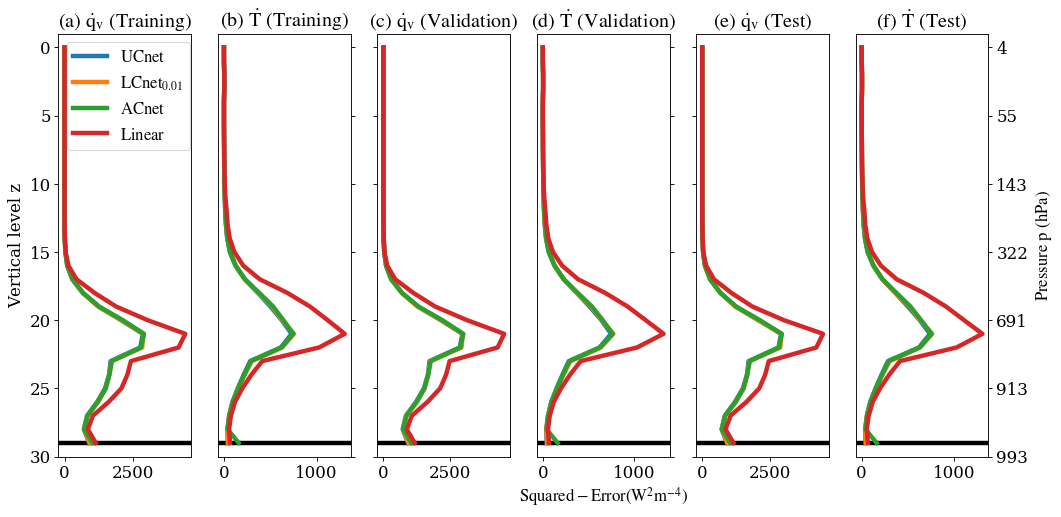

In [134]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\mathrm{Squared-Error}\\left(\\mathrm{W}^{2}\\mathrm{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6:
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig(pathHOME+'Fig_prof_comparison.pdf',format='pdf')

In [135]:
XMIN = -1.1
XMAX = 1.1

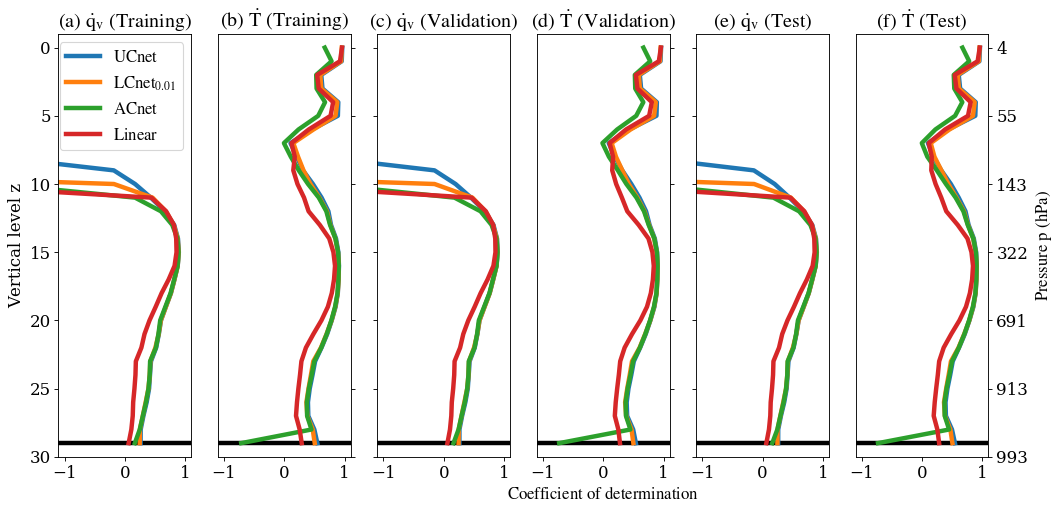

In [125]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(R2p[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.xlim((XMIN,XMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(R2p[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.xlim((XMIN,XMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\mathrm{Coefficient\ of\ determination}$')
    elif ifig==6:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6:
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig(pathHOME+'Fig_prof_comparison_R2.pdf',format='pdf')

## Sensitivity to Residual Level 

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/020_Sensitivity_Residual_level_Conservation.ipynb]

### From model

In [ ]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [ ]:
MSEv = {}
MSEt = {}
RESt = {}

for j,datas in enumerate(DATASET):
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    #print('j=',j,'and datas=',datas)
    data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so case #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.'+FOR,custom_objects=dict_lay)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+str(datas)+'.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))
        # 4) Load residuals
        path_end = 'mdres'+str(datas)+'.pkl'
        md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

In [ ]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [ ]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [ ]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$q_{'+nn[pm+1:pU]+'}T_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

In [ ]:
datas = 'valid'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])
    
datas = 'test'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])

In [ ]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [ ]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [ ]:
# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [ ]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEv = S['MSEv']
lev = S['lev']

In [ ]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [ ]:
NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [ ]:
TITLE = [r'$\mathrm{\left(a\right)\ \dot{q}_{v}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot{q}_{v}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [ ]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$\\mathrm{q}_{'+nn[pm+1:pU]+'}\\mathrm{T}_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\mathrm{Squared-Error}\\left(\\mathrm{W}^{2}\\mathrm{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig(pathHOME+'Fig_prof_reslev.pdf',format='pdf')

## Targetting residual bias by using weighted loss

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/036_ACnet_Targetted_Loss.ipynb]

### From large PKL file

In [ ]:
TITLE = [r'$\mathrm{\left(a\right)\ \dot{q}_{v}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot{q}_{v}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [ ]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen036.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen036.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

In [ ]:
mult_array = np.array([1,2,5,10,20])

In [ ]:
DATASET = ['valid','test']

In [ ]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:120],axis=0),
                np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

#Save figure
plt.savefig('Fig_prof_wloss.pdf',format='pdf')

In [ ]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:15],axis=0),
                np.linspace(0,14,num=15),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:105],axis=0),
                np.linspace(0,14,num=15))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

In [ ]:
for j,datas in enumerate(DATASET):
    for im,multiplier in enumerate(mult_array):
        print(datas,multiplier,'MSE',np.mean(S[datas]['MSE'][multiplier]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][multiplier]))

Save reduced data with mean and std of stats & res already calculated for less memory

In [29]:
S2 = S
for j,datas in enumerate(DATASET):
    for im,multiplier in enumerate(mult_array):
        S2[datas]['MSE'][multiplier] = (np.mean(S[datas]['MSE'][multiplier]),np.std(S[datas]['MSE'][multiplier]))
        S2[datas]['TRES'][multiplier] = (np.mean(S[datas]['TRES'][multiplier]),np.std(S[datas]['TRES'][multiplier]))

In [31]:
# hf = open(pathPKL+'2020_03_09_weightedloss.pkl','wb')
# pickle.dump(S2,hf)
# hf.close()

### From reduced data

In [129]:
hf = open(pathPKL+'2020_03_09_weightedloss.pkl','rb')
S = pickle.load(hf)
hf.close()

In [132]:
TITLE = [r'$\mathrm{\left(a\right)\ \dot{q}_{v}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot{q}_{v}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30
mult_array = np.array([1,2,5,10,20])
DATASET = ['valid','test']

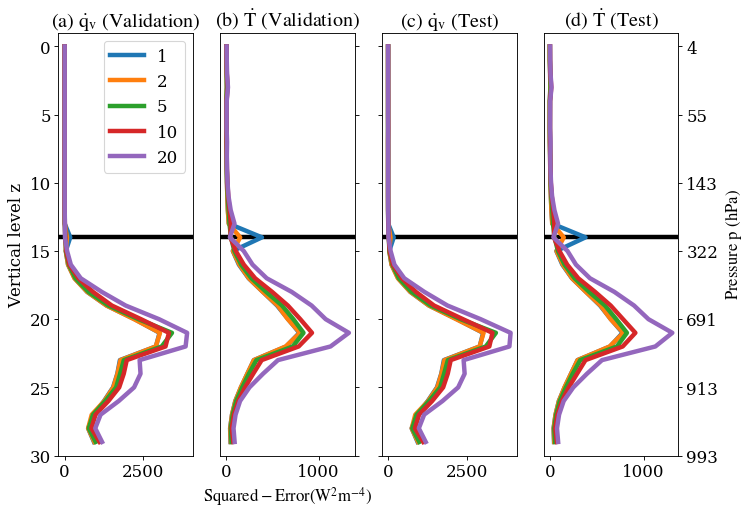

In [136]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:120],axis=0),
                np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\mathrm{Squared-Error}\\left(\\mathrm{W}^{2}\\mathrm{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

#Save figure
plt.savefig(pathHOME+'Fig_prof_wloss.pdf',format='pdf')

## Non-linearly constrained network

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/041_ACnet_Non_Linear.ipynb]

### From large PKL file

In [126]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL
col = ['k','r','b']
TITLE = [r'$\mathrm{\left(a\right)\dot\mathrm{RH}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot\mathrm{RH}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
DATASET = ['valid','test']

In [127]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [128]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen041.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen041.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

FileNotFoundError: [Errno 2] No such file or directory: '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2020_03_04_validgen041.pkl'

In [49]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        print('i=',i,'nn=',nn,'            ',end='\r')
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=NNname[i],color=col[i],linewidth=lw/2)
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
            
        
    if ifig==1: 
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2,label=NNname[i])
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
        plt.legend()
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_nl.pdf',format='pdf')

KeyError: 'valid'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa4439b1730> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)

kpathsea: Running mktexfmt latex.fmt
warning: kpathsea: configuration file texmf.cnf not found in these directories: /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/share/texmf/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-local/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf-dist/web2c:/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/texmf/web2c.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt: kpsewhich -var-value=TEXMFROOT failed, aborting early.
BEGIN failed--compilation aborted at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




<Figure size 800x560 with 1 Axes>

In [72]:
for j,datas in enumerate(DATASET):
    for i,nn in enumerate(NNarray):
        print(datas,nn,'MSE',np.mean(S[datas]['MSE'][nn]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][nn]))

valid 035_UCnet.hdf5 MSE 113.553785925987 Constraints Penalty 212366.71357283558
valid UCnetNL_10.hdf5 MSE 151.52250592805527 Constraints Penalty 3534.8022397378827
valid ACnetNL_10.hdf5 MSE 158.3656055163711 Constraints Penalty 0.0002111572260844254
test 035_UCnet.hdf5 MSE 113.71021776968766 Constraints Penalty 204024.85325491018
test UCnetNL_10.hdf5 MSE 151.2431999117424 Constraints Penalty 3492.563697030215
test ACnetNL_10.hdf5 MSE 157.3546145796691 Constraints Penalty 0.0002087446187475865


In [37]:
S2 = S
for j,datas in enumerate(DATASET):
    for i,nn in enumerate(NNarray):
        S2[datas]['MSE'][nn] = (np.mean(S[datas]['MSE'][nn]),np.std(S[datas]['MSE'][nn]))
        S2[datas]['TRES'][nn] = (np.mean(S[datas]['TRES'][nn]),np.std(S[datas]['TRES'][nn]))

In [38]:
# hf = open(pathPKL+'2020_03_09_nl.pkl','wb')
# pickle.dump(S2,hf)
# hf.close()

### From reduced data

In [137]:
hf = open(pathPKL+'2020_03_09_nl.pkl','rb')
S = pickle.load(hf)
hf.close()

In [140]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL
col = ['k','r','b']
TITLE = [r'$\mathrm{\left(a\right)\ \dot\mathrm{RH}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot\mathrm{RH}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
DATASET = ['valid','test']

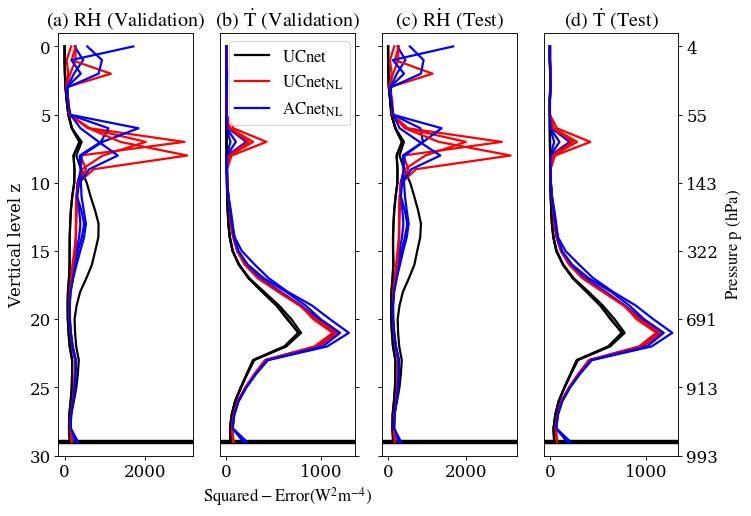

In [141]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        print('i=',i,'nn=',nn,'            ',end='\r')
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=NNname[i],color=col[i],linewidth=lw/2)
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
            
        
    if ifig==1: 
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2,label=NNname[i])
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\mathrm{Squared-Error}\\left(\\mathrm{W}^{2}\\mathrm{m}^{-4}\\right)$')
        plt.legend()
    elif ifig==4:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig(pathHOME+'Fig_prof_nl.pdf',format='pdf')

## ACnet Hyperparameter search

Read Jordan's excel file with hyperparameter search

In [5]:
import csv

In [16]:
S = {}
N = {}

In [29]:
with open('/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/CSV_DATA/Jordan_2020_08_03.csv', newline='') as csvfile:
    read = csv.reader(csvfile, delimiter=' ', quotechar='|')
    irow = 0
    for row in read:
        #print(row)
        if irow==0:
            istring = 0
            for string in row[0].split(","): 
                S[string] = {}; 
                N[istring] = string
                istring += 1
        else:
            istring = 0
            for string in row[0].split(","): 
                if istring==1 or string=='': S[N[istring]][irow] = string
                else: S[N[istring]][irow] = float(string)
                istring += 1
        irow += 1
            

In [31]:
S.keys()

dict_keys(['Trial-ID', 'Status', 'batch_norm', 'beta', 'dropout', 'ieres', 'imres', 'leaky_relu', 'lr', 'num_dense_nodes', 'num_layers', 'Objective', 'loss', 'val_loss', 'mean_squared_error', 'val_mean_squared_error'])

Focus on ieres, imres, MSE, and val_MSE to make plot

In [52]:
IERES = np.zeros((275,))
IMRES = np.zeros((275,))
BETA = np.zeros((275,))
MSE = np.zeros((275,))
VAL_MSE = np.zeros((275,))

for ind in range(275):
    IERES[ind] = S['ieres'][ind+1]
    IMRES[ind] = S['imres'][ind+1]
    BETA[ind] = S['beta'][ind+1]
    if S['mean_squared_error'][ind+1]=='': MSE[ind] = np.nan
    else: MSE[ind] = S['mean_squared_error'][ind+1]
    if S['val_mean_squared_error'][ind+1]=='': VAL_MSE[ind] = np.nan
    else: VAL_MSE[ind] = S['val_mean_squared_error'][ind+1]

In [55]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
#from colorspacious import cspace_converter
from collections import OrderedDict

Assign color based on MSE/VAL_MSE value

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([43., 34., 33., 39., 40., 31., 20., 13.,  5.,  3.]),
 array([157.96626 , 164.688184, 171.410108, 178.132032, 184.853956,
        191.57588 , 198.297804, 205.019728, 211.741652, 218.463576,
        225.1855  ]),
 <a list of 10 Patch objects>)

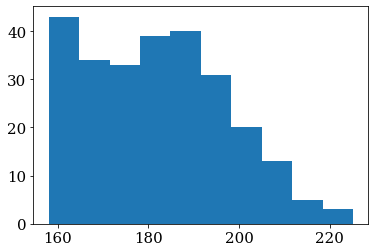

In [56]:
plt.hist(VAL_MSE)

(array([64., 25., 37., 37., 33., 34., 14., 13.,  2.,  2.]),
 array([163.94923 , 170.568344, 177.187458, 183.806572, 190.425686,
        197.0448  , 203.663914, 210.283028, 216.902142, 223.521256,
        230.14037 ]),
 <a list of 10 Patch objects>)

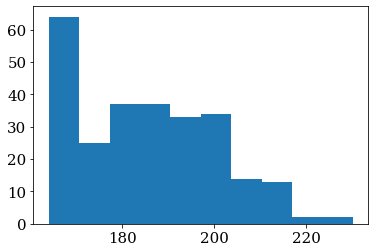

In [128]:
plt.hist(MSE)

In [93]:
BWR =  cm.get_cmap('bwr',256)

In [110]:
BWR(163)

(1.0, 0.7215686274509804, 0.7215686274509804, 1.0)

In [113]:
import math

In [129]:
VAL_COLOR = np.zeros((275,4))
TRA_COLOR = np.zeros((275,4))

for ind in range(275):
    if math.isnan(VAL_MSE[ind])==False: VAL_COLOR[ind,:] = BWR(int(256*(VAL_MSE[ind]-150)/(220-150)))
    else: VAL_COLOR[ind,:] = np.nan
        
    if math.isnan(MSE[ind])==False: TRA_COLOR[ind,:] = BWR(int(256*(MSE[ind]-150)/(220-150)))
    else: TRA_COLOR[ind,:] = np.nan

In [119]:
VAL_COLOR[:,:]

array([[0.25882353, 0.25882353, 1.        , 1.        ],
       [0.3372549 , 0.3372549 , 1.        , 1.        ],
       [0.32156863, 0.32156863, 1.        , 1.        ],
       ...,
       [1.        , 0.54117647, 0.54117647, 1.        ],
       [1.        , 0.76078431, 0.76078431, 1.        ],
       [1.        , 0.72156863, 0.72156863, 1.        ]])

In [120]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [123]:
VAL_COLOR[[ind],:]

array([[1.        , 0.72156863, 0.72156863, 1.        ]])

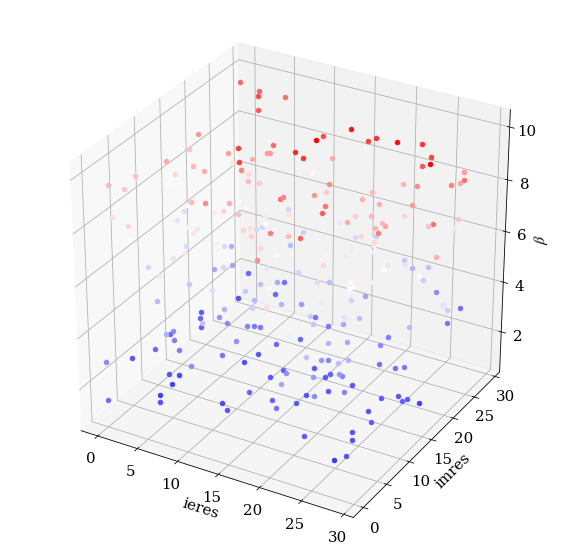

In [127]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ind in range(275):
    ax.scatter(IERES[ind], IMRES[ind], BETA[ind], c=VAL_COLOR[[ind],:], marker='o')
    
ax.set_xlabel('ieres')
ax.set_ylabel('imres')
ax.set_zlabel('$\\beta$')

plt.show()

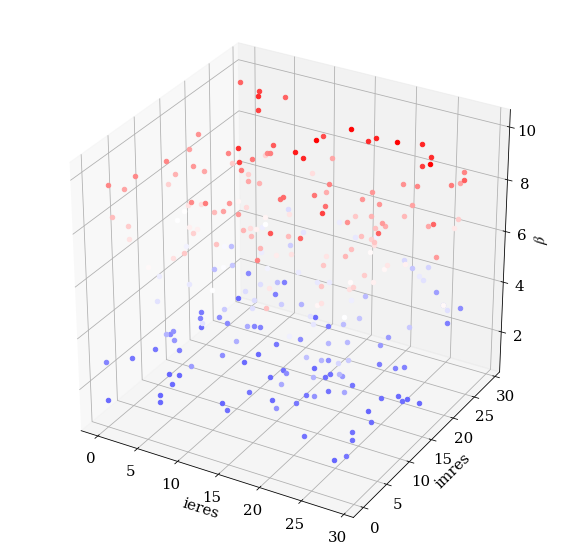

In [130]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ind in range(275):
    ax.scatter(IERES[ind], IMRES[ind], BETA[ind], c=TRA_COLOR[[ind],:], marker='o')
    
ax.set_xlabel('ieres')
ax.set_ylabel('imres')
ax.set_zlabel('$\\beta$')

plt.show()

# Tables

## Sensitivity to residual level

From reduced data

In [5]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [6]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']
lev = S['lev']

In [7]:
MSEt.keys()

dict_keys(['train', 'valid', 'test'])

In [8]:
MSEt['valid'].keys()

dict_keys(['Cm0_e0', 'Cm14_e14', 'Cm29_e29', 'Cm0_e29', 'Cm29_e0'])

In [9]:
TABLEname = 'Sens_reslev'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']
topline = "{\\small{}Dataset} & {\\small{}Metric} & $q_{0}T_{0}$ & $q_{14}T_{14}$ & $q_{29}T_{29}$ & $q_{0}T_{29}$ & $q_{29}T_{0}$\\tabularnewline\n"
caption = 'ACnets of varying residual levels for mass (m) and enthalpy (e) conservation, presented in Figure \\ref{Fig4} (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [10]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Sens_reslev printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Sens_reslev.txt


## Comparison across Linear, UC/AC/LCnets

From NN reduced data calculated in 2.1.1

In [11]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']

In [12]:
TABLEname = 'Comparison'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
NNarray = ['MLRL0','JNNL','JNNL0.01','JNNC']
topline = "{\\small{}Validation} & {\\small{}Metric} & {\\small{}Linear} & $\\mathrm{UC_{net}}$ & $\\mathrm{LC_{net}\\left(\\alpha=0.01\\right)}$ & $\\mathrm{AC_{net}}$\\tabularnewline\n"
caption = 'NNs presented in Figure \\ref{Fig3}b (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [13]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNarray):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Comparison printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Comparison.txt


Print with more decimals to better apprehend the difference between ACnet and UCnet

In [15]:
#f= open(path,"w+")
print("\\begin{table*}\n")
print("\\begin{centering}\n")
print("{\\small{}}%\n")
print("\\begin{tabular}{c|c|c|c|c|c|c}\n")
print(topline)
print("\\hline\n")
for j,datas in enumerate(DATASET):
    print("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(['JNNL','JNNC']):
        print(MSEt[datas][NNs][0])
        print(" pm ")
        print(MSEt[datas][NNs][1])
        if i<np.size(NNarray)-1: print(" &")
        else: print("\\tabularnewline\n")    
    print("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(['JNNL','JNNC']):
        print(RESt[datas][NNs][0])
        print(" pm ")
        print(RESt[datas][NNs][1])
        if i<np.size(NNarray)-1: print(" &")
        else: print("\\tabularnewline\n")
    if j<2: print("\\cline{1-1}\n")
print("\\hline\n") 
print("\\end{tabular}\n")
print("\\par\\end{centering}{\\small \\par}\n")
print("\n")
print("\\caption{")
print(caption)
print("}\n")
print("\\end{table*}\n")
#f.close()
#print('Table',TABLEname,'printed to',path)

\begin{table*}

\begin{centering}

{\small{}}%

\begin{tabular}{c|c|c|c|c|c|c}

{\small{}Validation} & {\small{}Metric} & {\small{}Linear} & $\mathrm{UC_{net}}$ & $\mathrm{LC_{net}\left(\alpha=0.01\right)}$ & $\mathrm{AC_{net}}$\tabularnewline

\hline

{\small{}Training} & {\small{}$\mathrm{MSE}$} &
145.1650609166888
 pm 
915.8063484057878
 &
149.4361188236711
 pm 
938.5944200225912
 &
set & {\small{}${\cal P}$} &
89.37954991806598
 pm 
79.67710549577953
 &
8.341574310624215e-10
 pm 
1.4126597898925849e-09
 &
\cline{1-1}

{\small{}Validation} & {\small{}$\mathrm{MSE}$} &
148.58633544642794
 pm 
943.7159911840228
 &
152.48820365795152
 pm 
962.9458728879752
 &
set & {\small{}${\cal P}$} &
91.35457393494937
 pm 
81.94606637820452
 &
8.398477035405565e-10
 pm 
1.458755057155484e-09
 &
\cline{1-1}

{\small{}Test} & {\small{}$\mathrm{MSE}$} &
146.5898421530561
 pm 
936.5237191436057
 &
150.4392433588806
 pm 
955.4555768911614
 &
set & {\small{}${\cal P}$} &
90.38922417966575
 pm 
81.9196373

## Comparison across LCnets of different conservation weights

### Create reduced data from model

In [17]:
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [18]:
#config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
config_fn = '/export/home/tbeucler/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
#data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'
data_fn = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/8col009_01_test.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
DATASET = ['train','valid','test']

In [19]:
MSEv = {}
MSEt = {}
RESt = {}

for j,datas in enumerate(DATASET):
    print('datas=',datas)
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    
    for alpha in alpha_array:
        print('alpha = ',str(alpha))
        NN = {}; md = {};

        # 1) Load model
        path = path_HDF5+'NNL'+str(alpha)+'.h5'
        NN = load_model(path,custom_objects=dict_lay)

        # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        path = path_HDF5+'NNL'+str(alpha)+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        MSEv[datas][alpha] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][alpha] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

        # 4) Calculate budget residuals and save in pickle file
        path = path_HDF5+'NNL'+str(alpha)+'res_'+datas+'.pkl'
        md.res = pickle.load(open(path,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][alpha] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

datas= train
alpha =  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


datas= valid
alpha =  0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


datas= test
alpha =  0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [17]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### Create table from reduced data

In [34]:
hf = open(pathPKL+'2020_03_11_across_alpha.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEt = S['MSEt']
RESt = S['RESt']
lev = S['lev']

In [35]:
TABLEname='Across_weights'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['train','valid','test']
DATANAM = ['Training','Validation','Test']
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
NN_array = [0,0.25,0.5,0.75,0.99] # Alpha values used for the table
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\alpha=0$ & $\\alpha=0.25$ & $\\alpha=0.5$ & $\\alpha=0.75$ & $\\alpha=0.99$\\tabularnewline\n"
caption = 'LCnets of varying weight $\\alpha $, presented in Figure \\ref{Fig3}a (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [36]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NN_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NN_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Across_weights printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Across_weights.txt


## Weighted loss to address residual bias

In [28]:
hf = open(pathPKL+'2020_03_09_weightedloss.pkl','rb')
S = pickle.load(hf)
hf.close()

DATASET = ['valid','test']
mult_array = np.array([1,2,5,10,20])

MSEt = {}
RESt = {}
for j,datas in enumerate(DATASET):
    MSEt[datas] = {}
    RESt[datas] = {}
    for im,multiplier in enumerate(mult_array):
        MSEt[datas][multiplier] = S[datas]['MSE'][multiplier]
        RESt[datas][multiplier] = S[datas]['TRES'][multiplier]

In [31]:
TABLEname='Targetted_loss'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['valid','test']
DATANAM = ['Validation','Test']
NNarray = mult_array
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\beta=1$ & $\\beta=2$ & $\\beta=5$ & $\\beta=10$ & $\\beta=20$\\tabularnewline\n"
caption = 'ACnets with varying loss multiplier $\\beta $  given to the residual levels ($q_{14}T_{14}$) (Mean MSE/Penalty $\\pm $ Standard deviation)'

In [32]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(mult_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(mult_array):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(RESt[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNarray)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Targetted_loss printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Targetted_loss.txt


## Non-linear UCnets and ACnets for RH

In [6]:
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL

# Save reduced data to make figure
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [7]:
hf = open(pathPKL+'2020_03_09_nl.pkl','rb')
S = pickle.load(hf)
hf.close()

DATASET = ['valid','test']
mult_array = np.array([1,2,5,10,20])

MSEt = {}
RESt = {}
for j,datas in enumerate(DATASET):
    print('j=',j,'datas=',datas)
    MSEt[datas] = {}
    RESt[datas] = {}
    for im,NNs in enumerate(NNarray):
        print('im=',im,'NNs=',NNs)
        MSEt[datas][NNs] = S[datas]['MSE'][NNs]
        RESt[datas][NNs] = S[datas]['TRES'][NNs]

j= 0 datas= valid
im= 0 NNs= 035_UCnet.hdf5
im= 1 NNs= UCnetNL_10.hdf5
im= 2 NNs= ACnetNL_10.hdf5
im= 3 NNs= UCnet_11.hdf5
im= 4 NNs= UCnetNL_11.hdf5
im= 5 NNs= ACnetNL_11.hdf5
im= 6 NNs= UCnet_12.hdf5
im= 7 NNs= UCnetNL_12.hdf5
im= 8 NNs= ACnetNL_12.hdf5
j= 1 datas= test
im= 0 NNs= 035_UCnet.hdf5
im= 1 NNs= UCnetNL_10.hdf5
im= 2 NNs= ACnetNL_10.hdf5
im= 3 NNs= UCnet_11.hdf5
im= 4 NNs= UCnetNL_11.hdf5
im= 5 NNs= ACnetNL_11.hdf5
im= 6 NNs= UCnet_12.hdf5
im= 7 NNs= UCnetNL_12.hdf5
im= 8 NNs= ACnetNL_12.hdf5


In [9]:
MSEt[datas][NNarray[im]]

(113.553785925987, 508.73208296636716)

In [11]:
NNmean = ['UC','UCnl','ACnl']
MSEtm = {}
REStm = {}
for j,datas in enumerate(DATASET):
    print('j=',j,'datas=',datas)
    MSEtm[datas] = {}
    REStm[datas] = {}
    for im,NNs in enumerate(NNmean):
        print('im=',im,'NNs=',NNs)
        MSEtm[datas][NNs] = ((MSEt[datas][NNarray[im]][0]+MSEt[datas][NNarray[3+im]][0]+MSEt[datas][NNarray[6+im]][0])/3,
                            (MSEt[datas][NNarray[im]][1]+MSEt[datas][NNarray[3+im]][1]+MSEt[datas][NNarray[6+im]][1])/3)
        REStm[datas][NNs] = ((RESt[datas][NNarray[im]][0]+RESt[datas][NNarray[3+im]][0]+RESt[datas][NNarray[6+im]][0])/3,
                            (RESt[datas][NNarray[im]][1]+RESt[datas][NNarray[3+im]][1]+RESt[datas][NNarray[6+im]][1])/3)

j= 0 datas= valid
im= 0 NNs= UC
im= 1 NNs= UCnl
im= 2 NNs= ACnl
j= 1 datas= test
im= 0 NNs= UC
im= 1 NNs= UCnl
im= 2 NNs= ACnl


In [23]:
TABLEname='ACnet_NL'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
#path_TXT = '/local/Tom.Beucler/SPCAM_PHYS/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
DATASET = ['valid','test']
DATANAM = ['Validation','Test']
NNarray = mult_array
topline = "{\\small{}Validation} & {\\small{}Metric} & $\\mathrm{UCnet}$ & $\\mathrm{UCnet_{NL}}$ & $\\mathrm{ACnet_{NL}}$\\tabularnewline\n"
caption = 'NNs presented in Figure \\ref{fig:D_schematic} (Ensemble mean of Mean MSE/Penalty $\\pm $ Standard deviation). MSE is calculated using relative humidity tendencies, explaining its smaller values.'

In [24]:
path

'/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/ACnet_NL.txt'

In [25]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("{\\small{}}%\n")
f.write("\\begin{tabular}{c|c|c|c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for j,datas in enumerate(DATASET):
    f.write("{\\small{}"+DATANAM[j]+"} & {\\small{}$\\mathrm{MSE}$} &")
    for i,NNs in enumerate(NNmean):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(MSEtm[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEtm[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(MSEtm[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(MSEtm[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNmean)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")    
    f.write("set & {\\small{}${\\cal P}$} &")
    for i,NNs in enumerate(NNmean):
        f.write(" {\\small{}$")
        f.write(("%.1e"%(REStm[datas][NNs][0]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(REStm[datas][NNs][0]))[4:])
        f.write("}\\pm")
        f.write(("%.1e"%(REStm[datas][NNs][1]))[:3])
        f.write("\\ 10^{")
        f.write(("%.1e"%(REStm[datas][NNs][1]))[4:])
        f.write("}$}")
        if i<np.size(NNmean)-1: f.write(" &")
        else: f.write("\\tabularnewline\n")
    if j<2: f.write("\\cline{1-1}\n")
f.write("\\hline\n") 
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:D_results}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table ACnet_NL printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/ACnet_NL.txt


# Reduced statistics for revisions round 2

## Vertical profiles of coef. of determination

### Sensitivity to residual level

In [116]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [95]:
R2p = {}
SQMEAN = {}
VAR = {}
HORVAR = {}
VAR_STD = {}
SQMEAN_STD = {}

for j,datas in enumerate(DATASET):
    R2p[datas] = {}
    VAR[datas] = {}
    HORVAR[datas] = {}
    SQMEAN[datas] = {}
    VAR_STD[datas] = {}
    SQMEAN_STD[datas] = {}
    #print('j=',j,'and datas=',datas)
    #data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    data_fn = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so case #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model('/DFS-L/DATA/pritchard/tbeucler/SPCAM/'+'HDF5_DATA/'+NNs+'.'+FOR,custom_objects=dict_lay,compile=False)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+str(datas)+'.pkl'
        md.stats = pickle.load(open('/DFS-L/DATA/pritchard/tbeucler/SPCAM/'+'HDF5_DATA/'+NNs+path_end,'rb'))
        # 4) Save in structures
        R2p[datas][NNs] = md.stats['hor_r2']
        VAR[datas][NNs] = np.mean(md.stats['true_var'],axis=(0,1))
        VAR_STD[datas][NNs] = np.std(md.stats['true_var'],axis=(0,1))
        HORVAR[datas][NNs] = md.stats['hor_tvar']
        SQMEAN[datas][NNs] = np.mean(md.stats['true_sqmean'],axis=(0,1))
        SQMEAN_STD[datas][NNs] = np.std(md.stats['true_sqmean'],axis=(0,1))
#         MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
#         MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))
#         # 4) Load residuals
#         path_end = 'mdres'+str(datas)+'.pkl'
#         md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
#         tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
#         RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

i = 0  so case # 1
Cm0_e0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 1  so case # 2
Cm14_e14
i = 2  so case # 3


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Cm29_e29
i = 3  so case # 4


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Cm0_e29
i = 4  so case # 5


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Cm29_e0


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [24]:
md.stats.keys()

dict_keys(['bias', 'mse', 'pred_mean', 'true_mean', 'pred_sqmean', 'true_sqmean', 'pred_var', 'true_var', 'r2', 'hor_tsqmean', 'hor_tmean', 'hor_mse', 'hor_tvar', 'hor_r2'])

In [26]:
md.stats['hor_r2'].shape

(218,)

(-1, 1)

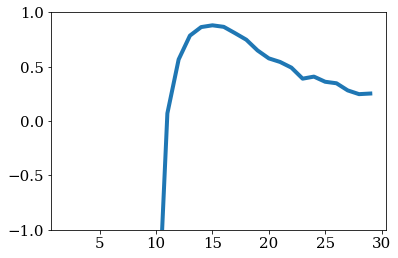

In [33]:
plt.plot(md.stats['hor_r2'][:30])
plt.ylim((-1,1))

In [35]:
md.stats['true_var'].shape

(64, 128, 218)

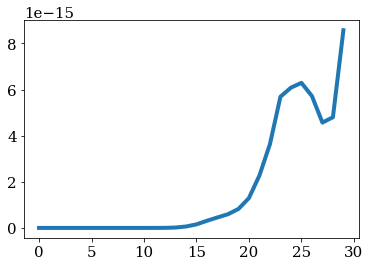

In [37]:
plt.plot(np.mean(md.stats['true_var'][:,:,:30],axis=(0,1)))

In [96]:
hf = open(pathPKL+'2020_09_23_sens2reslev.pkl','wb')
S = {"R2p":R2p,"VAR":VAR,"HORVAR":HORVAR,"SQMEAN":SQMEAN,"VAR_STD":VAR_STD,"SQMEAN_STD":SQMEAN_STD}
pickle.dump(S,hf)
hf.close()

### Comparison between linear, UCnet, LCnet

In [7]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
#data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'
data_fn = TRAINDIR + '8col009_01_test.nc'

In [8]:
R2p = {}
VAR = {}

for datas in DATASET:
    R2p[datas] = {}
    VAR[datas] = {}
    
for NNs in NNarray:
    print('NNs = ',NNs)
    R2p[datas][NNs] = {}
    VAR[datas][NNs] = {}
    
    for datas in DATASET:
        print('dataset=',datas)
        # 1) Load model
        print('Loading model')
        NN = load_model('/DFS-L/DATA/pritchard/tbeucler/SPCAM/'+'HDF5_DATA/'+NNs+'.h5',
                        custom_objects=dict_lay,
                        compile=False)

        # 2) Define model diagnostics object
        print('Building model diagnostics object')
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        print('Calculating mean-squared error')
        path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        R2p[datas][NNs] = md.stats['hor_r2']
        VAR[datas][NNs] = np.mean(md.stats['true_var'],axis=(0,1))
#         MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
#         MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

#         # 4) Calculate budget residuals and save in pickle file
#         print('Calculating residual')
#         path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
#         md.res = pickle.load(open(path,'rb'))
#         tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
#         RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

NNs =  JNNL
dataset= train
Loading model
Instructions for updating:
Colocations handled automatically by placer.
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= valid
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= test
Loading model
Building model diagnostics object


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
NNs =  JNNL0.01
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= valid
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= test
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NNs =  JNNC
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= valid
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= test
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NNs =  MLRL0
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= valid
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


dataset= test
Loading model
Building model diagnostics object
Calculating mean-squared error


/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [10]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2020_09_23_comparison.pkl','wb')
S = {"R2p":R2p,"VAR":VAR}
pickle.dump(S,hf)
hf.close()

### Weighted loss to address residual bias

Not needed as focus on HP search

## Response to referee B (MSE~Var)

In [97]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEv = S['MSEv']
lev = S['lev']

In [98]:
hf = open(pathPKL+'2020_09_23_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

VAR = S['VAR']
VAR_STD = S['VAR_STD']
HORVAR = S['HORVAR']
SQMEAN = S['SQMEAN']
SQMEAN_STD = S['SQMEAN_STD']

In [77]:
S.keys()

dict_keys(['R2p', 'VAR', 'HORVAR', 'SQMEAN'])

In [78]:
MSEv.keys()

dict_keys(['train', 'valid', 'test'])

In [79]:
VAR.keys()

dict_keys(['valid', 'test'])

In [88]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [89]:
NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['test']

In [90]:
TITLE = [r'$\mathrm{\left(a\right)\ \dot{q}_{v}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\ \dot{T}\ \left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\ \dot{q}_{v}\ \left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\ \dot{T}\ \left(\mathrm{Test}\right)}$']
YMIN = 10
YMAX = 30

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


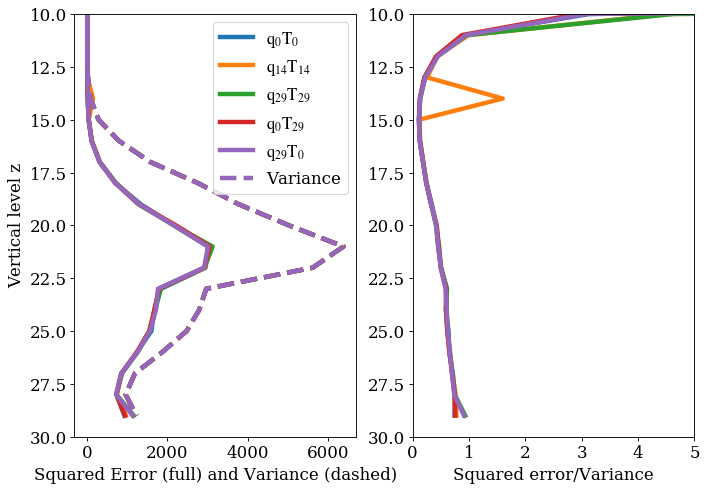

In [109]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

for j,datas in enumerate(DATASET):
    ax = f.add_subplot(1,2,1)
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')
        
        LIN = ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$\\mathrm{q}_{'+nn[pm+1:pU]+'}\\mathrm{T}_{'+nn[pe+1:]+'}$')
        COL = LIN[0].get_color()
        if i==4: LAB = 'Variance'
        else: LAB = ''
        ax.plot((VAR[datas][nn]*(md.valid_gen.output_transform.scale**2))[:30],
                np.linspace(0,29,num=30),linestyle='--',color=COL,label=LAB)
    
    plt.legend()
    plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.xlabel('Squared Error (full) and Variance (dashed)')
    
    ax2 = f.add_subplot(1,2,2)
    
    for i,nn in enumerate(NNarray):
        LIN = ax2.plot(MSEv[datas][nn][:30]/((SQMEAN[datas][nn]*(md.valid_gen.output_transform.scale**2))[:30])**1,
                      np.linspace(0,29,num=30))
#         LIN = ax2.plot(VAR[datas][nn][:30]/SQMEAN_STD[datas][nn][:30],
#                       np.linspace(0,29,num=30))
    #plt.ylabel('Vertical level z')
    plt.xlim((0,5))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.xlabel('Squared error/Variance')

pathHOME = '/export/home/tbeucler/'
plt.savefig(pathHOME+'Fig_refB_1525.pdf',format='pdf')

In [30]:
dir(LIN)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [ ]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$\\mathrm{q}_{'+nn[pm+1:pU]+'}\\mathrm{T}_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\mathrm{Squared-Error}\\left(\\mathrm{W}^{2}\\mathrm{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\mathrm{Pressure\\ p\\ \\mathrm{\\left(\\mathrm{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab].replace('−', '-')))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
#plt.savefig(pathHOME+'Fig_prof_reslev.pdf',format='pdf')